In [1]:
import cirq
import numpy as np
from typing import List
import sys
sys.modules["tqdm"] = None # distable tqdm for cleaner notebook rendering
from mitiq.shadows.shadows import *
from mitiq.shadows.shadows_utils import *
from mitiq import MeasurementResult
from mitiq.interface.mitiq_cirq.cirq_utils import (
    sample_bitstrings as cirq_sample_bitstrings,
)
# set random seed
np.random.seed(666)

In [2]:
# number of qubits in the circuit
num_qubits: int = 4
# qubits in the circuit prepared in the $|0\rangle$ state
qubits: List[cirq.Qid] = cirq.LineQubit.range(num_qubits)

# defining random parameters for the circuit
# np.random.seed(666)
params: np.ndarray = np.random.randn(2 * num_qubits)

# define circuit
def simple_test_circuit(
    params: np.ndarray, qubits: List[cirq.Qid]
) -> cirq.Circuit:
    circuit: cirq.Circuit = cirq.Circuit()
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.H(qubit))
        circuit.append(cirq.ry(params[i])(qubit))
    for i in range(num_qubits - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rz(params[i + num_qubits])(qubit))
    return circuit


# print the circuit
test_circuits = simple_test_circuit(params, qubits)
print(simple_test_circuit(params, qubits))

0: ───H───Ry(0.262π)───@───Rz(-0.182π)──────────────────────────────
                       │
1: ───H───Ry(0.153π)───X───@─────────────Rz(-0.035π)────────────────
                           │
2: ───H───Ry(0.374π)───────X─────────────@─────────────Rz(0.006π)───
                                         │
3: ───H───Ry(0.289π)─────────────────────X─────────────Rz(-0.3π)────


In [3]:
def cirq_executor(
    circuit: cirq.Circuit,
) -> MeasurementResult:
    return cirq_sample_bitstrings(
        circuit,
        noise_level=(0,),
        shots=1,
        sampler=cirq.Simulator(),
    )

In [4]:
shadow_quantum_processing(test_circuits, cirq_executor, 2)

(['1100', '0000'], ['ZXYZ', 'XYYY'])

In [5]:
# error rate of state reconstruction epsilon < 1.
epsilon = 1
# number of total measurements should perform for error rate epsilon
n_total_measurements = n_measurements_tomography_bound(epsilon, num_qubits)

print("n_total_measurements = {}".format(n_total_measurements))
shadow_outcomes = shadow_quantum_processing(
    test_circuits, cirq_executor, n_total_measurements
)

n_total_measurements = 8704


In [6]:
# get shadow reconstruction of the density matrix
output = classical_post_processing(
    shadow_outcomes,
    state_reconstruction=True,
)
rho_shadow = output["reconstructed_state"]

In [7]:
# Compute the ideal state vector described by the input circuit.
state_vector = test_circuits.final_state_vector().reshape(-1, 1)
# Compute the density matrix.
rho_true = state_vector @ state_vector.conj().T

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Setting the style
sns.set_style("white")

# Calculate min and max values across the datasets
vmin = min(
    np.abs(rho_shadow).min(),
    np.abs(rho_true).min(),
    np.abs(rho_true - rho_shadow).min(),
)
vmax = max(
    np.abs(rho_shadow).max(),
    np.abs(rho_true).max(),
    np.abs(rho_true - rho_shadow).max(),
)

# Creating a figure with three subplots (1 row, 3 columns)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plotting the first image on the first subplot
im1 = axs[0].imshow(np.real(rho_shadow), cmap="Blues", vmin=vmin, vmax=vmax)
axs[0].set_title(r"$\rho_{ij}^{\mathrm{shadow}}$")

# Plotting the second image on the second subplot
im2 = axs[1].imshow(np.real(rho_true), cmap="Blues", vmin=vmin, vmax=vmax)
axs[1].set_title(r"$\rho_{ij}$")

# Plotting the third image on the third subplot
im3 = axs[2].imshow(
    np.abs(rho_true - rho_shadow), cmap="Blues", vmin=vmin, vmax=vmax
)
axs[2].set_title(r"$|\rho_{ij}^{\mathrm{shadow}}-\rho_{ij}|$")

# Adjust the space between plots
plt.subplots_adjust(wspace=0.3)

# Add a shared colorbar
cbar = fig.colorbar(
    im3, ax=axs.ravel().tolist(), orientation="vertical", shrink=0.67, pad=0.05
)

# Show the figure with three side-by-side plots
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# compute fidelity and operator 2-norm
b_strings, u_strings = shadow_outcomes
b_lists = np.array(b_strings)
u_lists = np.array(u_strings)
n_measurement_list = np.arange(
    int(n_total_measurements / 100),
    n_total_measurements,
    int(n_total_measurements / 10),
)
# repeat the experiment 3 times
n_runs = 3
fidelity_list = []
operator_2_norm_list = []

# Create a new dataframe to store the results
df = pd.DataFrame(
    columns=["n_measurement", "run", "fidelity", "operator_2_norm"]
)

# Loop over the different number of measurements
for n_measurement in n_measurement_list:
    # Repeat the experiment 3 times
    for run in range(n_runs):
        # randomly sample from the measurement outcomes, with replacement
        sample_idx = np.random.choice(
            len(b_lists), size=n_measurement, replace=True
        )
        shadow_subset = (b_lists[sample_idx], u_lists[sample_idx])
        # perform shadow state reconstruction
        rho_shadow = classical_post_processing(
            shadow_outcomes=shadow_subset,
            state_reconstruction=True,
        )["reconstructed_state"]

        # compute fidelity and operator 2-norm
        fidelity_val = fidelity(rho_true, rho_shadow)
        norm_val = np.linalg.norm(
            rho_shadow - rho_true, ord=None, axis=None, keepdims=False
        )
        # store the results
        df = pd.concat(
            [df, pd.DataFrame({
                "n_measurement": [n_measurement],
                "run": [run],
                "fidelity": [fidelity_val],
                "operator_2_norm": [norm_val],
            })],
            ignore_index=True,
        )
        

In [ ]:
plt.figure()
sns.lineplot(
    data=df,
    x="n_measurement",
    y="fidelity",
)
plt.xlabel("Number of Measurements")
plt.legend()
plt.title(r"Fidelity: $F(\rho^{\rm shadow}, \rho)$")
plt.xlabel(r"N Measurements-$N$")
plt.ylabel(r"Fidelity")
# plot x range
plt.xlim(1000, n_total_measurements)

plt.figure()
sns.lineplot(
    data=df,
    x="n_measurement",
    y="operator_2_norm",
)
plt.title(r"$L_2$-Norm distance: $\|\rho^{\rm shadow} - \rho\|_2$")
plt.xlabel(r"N Measurements-$N$")
plt.ylabel(r"$L_2$ distance")
plt.legend()
# plot range 0.35 to 1.0
plt.ylim(0.35, 1.0)
# plot x range
plt.xlim(1000, n_total_measurements)

In [9]:
from mitiq import Observable, PauliString

# from cirq import LineQubit

r"""
 define the observables $\{X_iX_{i+1}\}_{i\leq n-1}$
"""
from mitiq import PauliString

list_of_paulistrings = (
    [
        PauliString("XX", support=(i, i + 1), coeff=1)
        for i in range(num_qubits - 1)
    ]
    + [PauliString("YY", support=(i, i + 1)) for i in range(num_qubits - 1)]
    + [
        PauliString("ZZ", support=(i, i + 1), coeff=1)
        for i in range(num_qubits - 1)
    ]
)

for observables in list_of_paulistrings:
    print(observables)
# print the type of the observables

X(q(0))*X(q(1))
X(q(1))*X(q(2))
X(q(2))*X(q(3))
Y(q(0))*Y(q(1))
Y(q(1))*Y(q(2))
Y(q(2))*Y(q(3))
Z(q(0))*Z(q(1))
Z(q(1))*Z(q(2))
Z(q(2))*Z(q(3))


In [10]:
r"""
Solve for the exact expectation values with mitiq
:math:`\langle O\rangle_{\rho} = \mathrm{Tr}(\rho O)`
"""
from functools import partial
from mitiq.interface import mitiq_cirq

expval_exact = []
for i, pauli_string in enumerate(list_of_paulistrings):
    obs = Observable(pauli_string)
    exp = obs.expectation(
        simple_test_circuit(params, qubits),
        execute=partial(mitiq_cirq.compute_density_matrix, noise_level=(0.0,)),
    )

    expval_exact.append(exp)

In [11]:
r"""
Minimum number of snapshots N required for predicting the expectation values of the observables with error rate epsilon.
"""
# create a grid of errors epsilon = 0.2, 0.4, 0.6, 0.8 defined as epsilon in the Theorem
epsilon_grid = [1 - 0.2 * x for x in range(0, 5, 1)]
n_total_measurements = []
expectation_value_shadow = []
# define failure_rate delta in Theorem
failure_rate = 0.01
# For each error in epsilon_grid
for error in epsilon_grid:

    # get the number of total shadow measurements and groups need to split into
    # needed so that the absolute error < epsilon, and accuracy >= 1 - failure_rate.
    r, k = n_measurements_opts_expectation_bound(
        error, list_of_paulistrings, failure_rate
    )
    n_total_measurements.append(r)

    shadow_outputs = shadow_quantum_processing(test_circuits, cirq_executor, r)
    output = classical_post_processing(
        shadow_outcomes=shadow_outputs,
        observables=list_of_paulistrings,
        k_shadows=k,
    )

    # estimate all the observables in {O_i}_i with error rate epsilon and failure rate delta
    expectation_value_shadow.append(list(output.values()))

    # totle number of snpshots required for error rate = epsilon
    print(
        f"{r} totel number of snapshots required for error rate {int((error+1e-10)*10)/10}"
    )

510 totel number of snapshots required for error rate 1.0
797 totel number of snapshots required for error rate 0.8
1416 totel number of snapshots required for error rate 0.6
3186 totel number of snapshots required for error rate 0.4
12743 totel number of snapshots required for error rate 0.2


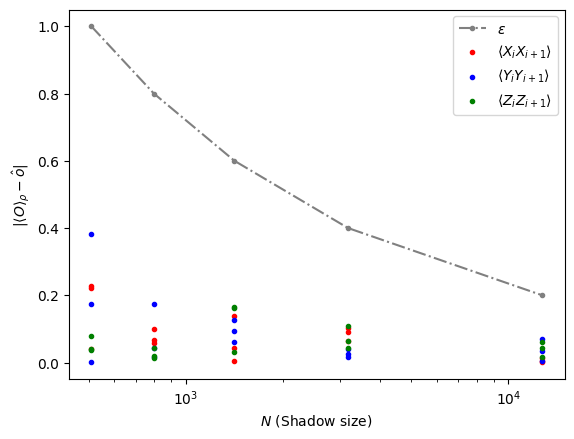

In [12]:
import matplotlib.pyplot as plt

# plot bound
plt.plot(
    n_total_measurements,
    [e for e in epsilon_grid],
    linestyle="-.",
    color="gray",
    label=rf"$\epsilon$",
    marker=".",
)

# Plot exact expectation values
for i, obs in enumerate(expval_exact):
    if i < len(expval_exact) // 3:
        color = "red"
    elif len(expval_exact) // 3 <= i < 2 * len(expval_exact) // 3:
        color = "blue"
    else:
        color = "green"
    obs = expval_exact[i]
    for j, error in enumerate(epsilon_grid):
        plt.scatter(
            [n_total_measurements[j]],
            [np.abs(obs - expectation_value_shadow[j][i])],
            marker=".",
            color=color,
        )

plt.xlabel(r"$N$ (Shadow size) ")
plt.ylabel(r"$|\langle O \rangle_{\rho} - \hat{o}|$")

# legend dots
plt.scatter(
    [], [], marker=".", color="red", label=r"$\langle X_i X_{i+1} \rangle$"
)
plt.scatter(
    [], [], marker=".", color="blue", label=r"$\langle Y_i Y_{i+1} \rangle$"
)
plt.scatter(
    [], [], marker=".", color="green", label=r"$\langle Z_i Z_{i+1} \rangle$"
)
plt.legend()
# x log scale
plt.xscale("log")
plt.show()